In [1]:
# Preliminaries
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as stats
from umc_module import main_program # import self define module

In [2]:
# data generation
def data_generator(n,mu,prob,group=[0.7,0.3]):
    # input vector mu=(mu1,mu2) stands for different means for two groups
    # input vector prob=(p1,p2) stands for different accuracy for group,value

    # generate real data
    output=pd.DataFrame(columns=['label','value','real_label','real_value'])
    output['real_label']=np.random.choice(a=[0,1],size=n,replace=True,p=group) # group_1 disinformation, 0 otherwise
    srl1=sum(output['real_label'])
    output.loc[output['real_label']==0,'real_value']=np.random.choice(a=[0,1],size=n-srl1,replace=True,p=[1-mu[0],mu[0]])
    output.loc[output['real_label']==1,'real_value']=np.random.choice(a=[0,1],size=srl1,replace=True,p=[1-mu[1],mu[1]])

    # generate inaccuracy data
    output.loc[output['real_label']==0,'label']=np.random.choice(a=[0,1],size=n-srl1,replace=True,p=[prob[0],1-prob[0]])
    output.loc[output['real_label']==1,'label']=np.random.choice(a=[0,1],size=srl1,replace=True,p=[1-prob[0],prob[0]])

    srv1=sum(output['real_value'])
    output.loc[output['real_value']==0,'value']=np.random.choice(a=[0,1],size=n-srv1,replace=True,p=[prob[1],1-prob[1]])
    output.loc[output['real_value']==1,'value']=np.random.choice(a=[0,1],size=srv1,replace=True,p=[1-prob[1],prob[1]])
    
    return(output.astype(int))

In [3]:
# convert data into input data of self-define t test
def convert_df(data,prob):
    v=np.zeros(shape=(data.shape[0],2))
    v[data[data.label==0].index,1]=1-prob[0]
    v[data[data.label==1].index,1]=prob[0]

    v[data[data.value==0].index,0]=1-prob[1] # Question: how to define x?
    v[data[data.value==1].index,0]=prob[1]
    return(v)

In [4]:
def MC_compare(m,n,mu,prob):
    output=np.zeros(shape=(m,2))
    for i in range(m):
        df=data_generator(n,mu,prob)
        v=convert_df(df,prob)
        output[i,0]=main_program.uncertain_t(v,tail=2,value='p_value')
        output[i,1]=stats.ttest_ind(df[df.real_label==1]['real_value'],df[df.real_label==0]['real_value']).pvalue
    return(output)

In [5]:
# test 1
mu=[0.57,0.43] # true mean of two group
prob=np.ones(shape=(21,2)) # classification accuracy
prob[:,0]=np.arange(0.60, 1.01, 0.02)
prob[:,1]=np.arange(0.60, 1.01, 0.02)
prob[20]=[1,1]

In [6]:
np.random.seed(2022)
res_list=np.zeros(shape=(21,100,2))
mean_pvalue=np.zeros(shape=(21,2))
se_pvalue=np.zeros(shape=(21,2))
m=100;n=1000
for i in range(21):
    res_list[i]=MC_compare(m,n,mu,prob[i])
    mean_pvalue[i]=np.mean(res_list[i],axis=0)
    se_pvalue[i]=np.sqrt(np.var(res_list[i],axis=0)/m)

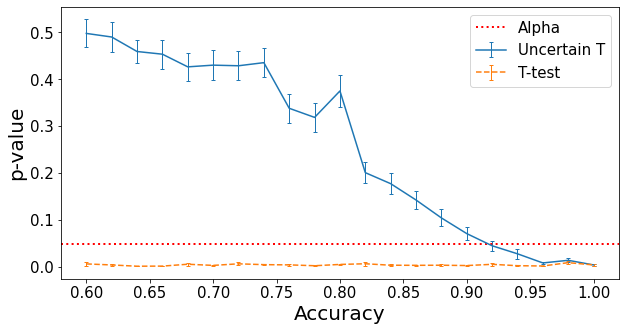

In [7]:
plt.figure(figsize=(10,5))
plt.xlabel("Accuracy",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("p-value",fontsize=20)
plt.errorbar(prob[:,0],mean_pvalue[:,0],yerr=se_pvalue[:,0],fmt='-',elinewidth=1,capsize = 2,label="Uncertain T")
plt.errorbar(prob[:,0],mean_pvalue[:,1],yerr=se_pvalue[:,1],linestyle='--',elinewidth=1,capsize = 2,label="T-test")
plt.axhline(0.05,linestyle=':',c='red',linewidth=2,label='Alpha')
plt.legend(fontsize=15)

In [8]:
# test 2 
prob1=[0.75,0.75] # true mean of two group
prob2=[0.8,0.8]
prob3=[0.85,0.85]
prob4=[0.9,0.9]
mu=np.ones(shape=(81,2)) # classification accuracy
mu[:,0]=np.arange(0.10, 0.91, 0.01)
mu[:,1]=np.arange(0.10, 0.91, 0.01)[::-1]

In [19]:
np.random.seed(2022)
res_list=np.zeros(shape=(81,100,2))
power_list=np.zeros(shape=(81,2))
m=100;n=1000
for i in range(81):
    res_list[i]=MC_compare(m,n,mu[i],prob1) # accuracy=0.75
    power_list[i]=np.mean(res_list[i]<=0.05,axis=0)

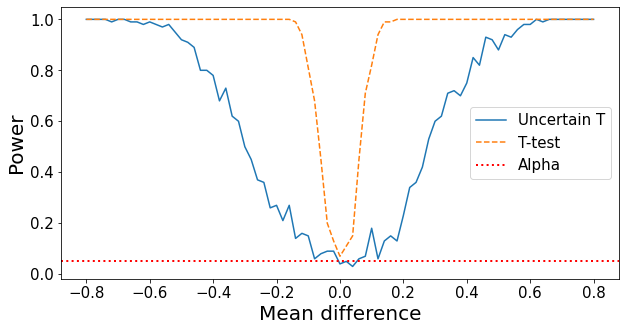

In [20]:
x=mu[:,0]-mu[:,1]
plt.figure(figsize=(10,5))
plt.xlabel("Mean difference",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Power",fontsize=20)
plt.plot(x,power_list[:,0],label='Uncertain T')
plt.plot(x,power_list[:,1],linestyle='--',label="T-test")
plt.axhline(0.05,linestyle=':',c='red',linewidth=2,label='Alpha')
plt.legend(fontsize=15)

In [13]:
np.random.seed(2022)
res_list=np.zeros(shape=(81,100,2))
power_list=np.zeros(shape=(81,2))
m=100;n=1000
for i in range(81):
    res_list[i]=MC_compare(m,n,mu[i],prob2) # accuracy=0.80
    power_list[i]=np.mean(res_list[i]<=0.05,axis=0)

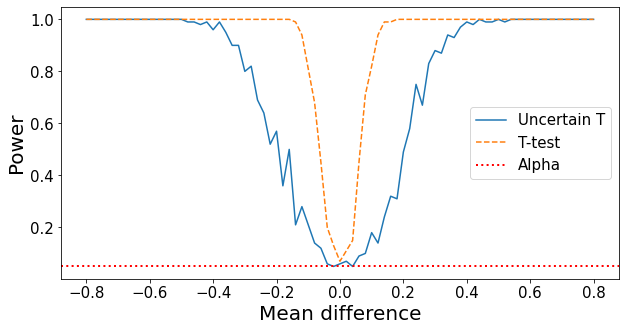

In [14]:
x=mu[:,0]-mu[:,1]
plt.figure(figsize=(10,5))
plt.xlabel("Mean difference",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Power",fontsize=20)
plt.plot(x,power_list[:,0],label='Uncertain T')
plt.plot(x,power_list[:,1],linestyle='--',label="T-test")
plt.axhline(0.05,linestyle=':',c='red',linewidth=2,label='Alpha')
plt.legend(fontsize=15)

In [15]:
np.random.seed(2022)
res_list=np.zeros(shape=(81,100,2))
power_list=np.zeros(shape=(81,2))
m=100;n=1000
for i in range(81):
    res_list[i]=MC_compare(m,n,mu[i],prob3) # accuracy=0.85
    power_list[i]=np.mean(res_list[i]<=0.05,axis=0)

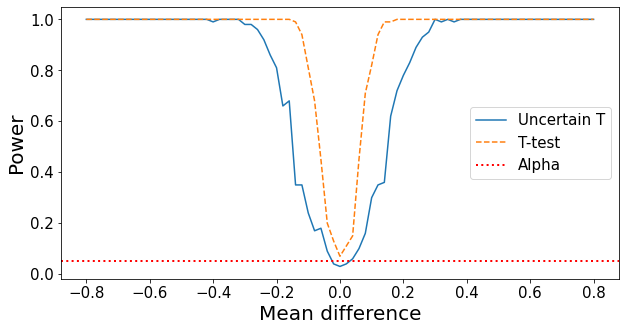

In [16]:
x=mu[:,0]-mu[:,1]
plt.figure(figsize=(10,5))
plt.xlabel("Mean difference",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Power",fontsize=20)
plt.plot(x,power_list[:,0],label='Uncertain T')
plt.plot(x,power_list[:,1],linestyle='--',label="T-test")
plt.axhline(0.05,linestyle=':',c='red',linewidth=2,label='Alpha')
plt.legend(fontsize=15)

In [17]:
np.random.seed(2022)
res_list=np.zeros(shape=(81,100,2))
power_list=np.zeros(shape=(81,2))
m=100;n=1000
for i in range(81):
    res_list[i]=MC_compare(m,n,mu[i],prob4) # accuracy=0.9
    power_list[i]=np.mean(res_list[i]<=0.05,axis=0)

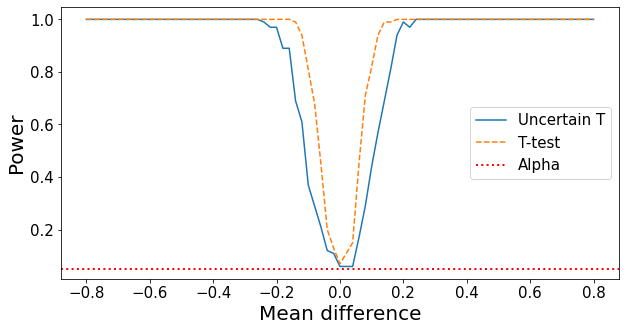

In [18]:
x=mu[:,0]-mu[:,1]
plt.figure(figsize=(10,5))
plt.xlabel("Mean difference",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Power",fontsize=20)
plt.plot(x,power_list[:,0],label='Uncertain T')
plt.plot(x,power_list[:,1],linestyle='--',label="T-test")
plt.axhline(0.05,linestyle=':',c='red',linewidth=2,label='Alpha')
plt.legend(fontsize=15)

In [27]:
# test 3
np.random.seed(100)
mu=[0.405,0.595]
p=[0.75,0.75]
m=100
n=10000
res=MC_compare(m,n,mu,p)

In [29]:
# self-define result; true result
np.mean(res[:,0]>0.05),np.mean(res[:,1]>0.05)

(0.01, 0.0)